# The Direct linear transform (DLT)

Direct Solution for Computing Fundamental (for uncalibrated camera) and Essential (for calibrated camera) Matrix.

The Fundamental and Essential Matrices contain all information about the relative orientation (of two cameras) that can be extracted from corresponding image points.

### Our aim is to derive the relative pose of camera $C_2$ w.r.t. $C_1$.

To achieve this we use the coplanarity constraint: 
$${x'_n}^T F {x''_n}^T = 0$$
where $x'_n$ and $x''_n$ are corresponding image points in image 1 and image 2 respectively. (This constraint comes from the epipolar geometry.)


In [219]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

(4032, 3024)

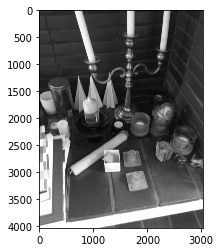

In [220]:
# Loading images. 
basename = "fireplace"
cam_1_path = "./img/" + basename + "_l" + ".JPG"
cam_2_path = "./img/" + basename + "_r" + ".JPG"

img1 = cv2.imread(cam_1_path, 0)
img2 = cv2.imread(cam_2_path, 0)


plt.imshow(img1, cmap="gray")
np.shape(img1)

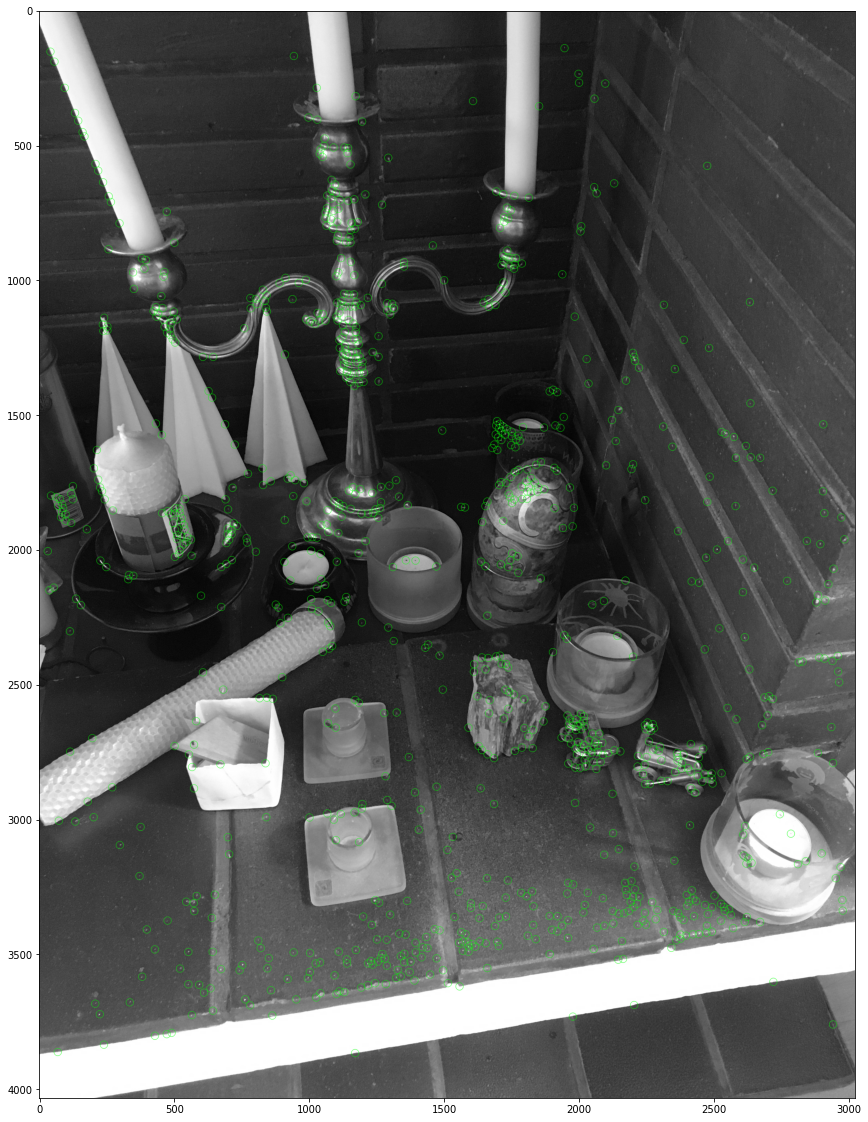

In [221]:
# Extracting features from images.
orb = cv2.ORB_create()

""" kp1 = orb.detect(img_1, None)
kp2 = orb.detect(img_2, None) """

features1 = cv2.goodFeaturesToTrack(img1, 1000, qualityLevel=0.01, minDistance=14)
features2 = cv2.goodFeaturesToTrack(img2, 1000, qualityLevel=0.01, minDistance=14)
kp1 = [cv2.KeyPoint(x=p[0][0], y=p[0][1], _size = 28) for p in features1]
kp2 = [cv2.KeyPoint(x=p[0][0], y=p[0][1], _size = 28) for p in features2]

# Compute descriptions for extracted features.
kp1, des1 = orb.compute(img1, kp1)
kp2, des2 = orb.compute(img2, kp2)

img_with_keypoints = cv2.drawKeypoints(img2, kp2, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20, 20))
plt.imshow(img_with_keypoints)


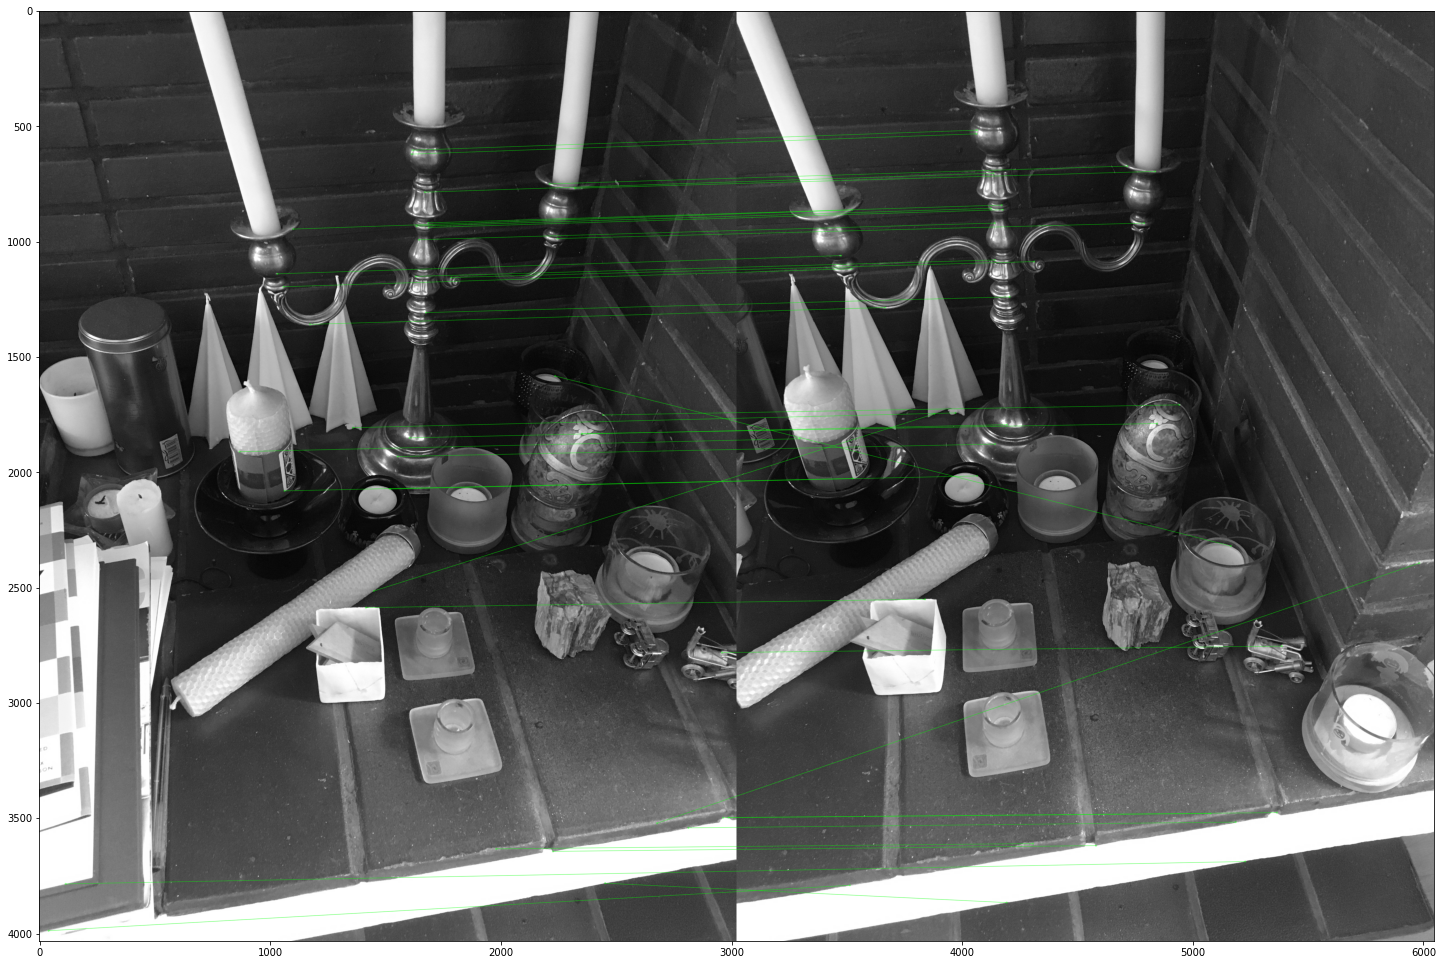

In [222]:
# Matching features to obtain point correspondences.

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

matches = sorted(matches, key = lambda x:x.distance)

matches_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:len(matches)//10] ,None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchColor=(0, 255, 0))
plt.figure(figsize=(25, 25))
plt.imshow(matches_img)


### The constraints
Now that we have our matching image points we can start to solve for F. We can reshape the epipolar constraint in to the form $a_n^T f = 0$, where $f$ and $a_n$ are $9 \times 1$ vectors. $f$ is the reshaped form of $F$ (in a row major order) and $a_n = x'_n \otimes x''_n$, where $\otimes$ is the kronecker product.

Let us construct a linear system of equations:
$ A f = 0 $ where $A$ is a $m \times 9$ matrix with its rows consisting of $a_n$. In order for the equation to have a solution, $A$ must be at most of rank 8. Assuming that our "match vectors" $a_n$ are independent (not too close to each other), we get a suitable $A$ matrix candidate by stacking 8 of such "match vectors" transposed on top of each other. 

Note that f will be fixed only up to scale (as the nullspace of $A$ contains infinitely many points). This is ok as f is a Homogeneus matrix.

##### Handling errors in the detection and matching process.
Our matches will have errors and the feature detection will not be perfectly accurate. We can employ different schemes to deal with this.
*   One option is to use a RANSAC approach. $A$ will then be a $8 \times 9$ matrix. Where the rows are randomly sampled from $a_n$.
*   We could also make $A$ taller (stacking all $a_n$) and obtain f from the 9:th singular vector, corresponding to the smallest singular value. In this case the resulting $F$ matrix will be regular and the rank 2 condition of $F$ must be seperately enforced. We can do this by doing an SVD on F and setting the smallest singular value to zero. The resulting $\hat F$ should approximate $F$ as closely as possible and be of rank 2 as required.

In [237]:
_pts1 = []
_pts2 = []
# Construct A
num_matches = 500
A = []

_num_corresp_used = min(num_matches, len(matches))
print("Using {} point correspondences.".format(_num_corresp_used))
for match in matches[:_num_corresp_used]:
    # Find point and convert to homogeneous coords.
    point1 = (*kp1[match.queryIdx].pt, 1)
    point2 = (*kp2[match.trainIdx].pt, 1)
    _pts1.append(point1[:2])
    _pts2.append(point2[:2])
    # Kronecker product
    a = np.kron(point1, point2)
    A.append(a)

A = np.mat(A)

# SVD
U, S, Vt = np.linalg.svd(A)


print(S)
# Sanity check. 
# Singular vectors corresponding to smaller singular values 
# should be stretched less by A.
sc1 = [np.linalg.norm(A*t) for t in [f.T for f in Vt]]
assert(all(sc1 == np.flip(np.sort(sc1))))

# Slect f  (vector in (closest to) the nullspace of A)
f = Vt[8]
F = np.reshape(f, (3,3))

# F will be ill conditioned. Condition F to be of rank 2.
U, S, Vt = np.linalg.svd(F)
S[2] = 0
S = np.diag(S)
F = U*S*Vt
print(S)


Using 389 point correspondences.
[1.84002043e+08 4.77255554e+07 2.10786042e+07 1.13363428e+07
 1.71488288e+04 7.54689008e+03 4.77313042e+03 2.51056971e+03
 2.10858853e+00]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.76127174e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


Next we will extract the rotation and translation(up to scale) from F.
For this we first compute the essential matrix $E = $.

The complanarity constraint we used to obtain $F$ was derived from the fact that the base vector $b$, the direction vector of point $X_n$ from $C_1$ $X'_n$, and the direction vector of point $X_n$ from $C_2$ $X''_n$ are coplanar. This constraint holds also in cases that are not physically correct like the direction vectors from the camera positions intersecting behind one or both cameras. Such impossible configurations result e.g. from inverting any one of $b$, $X'_n$, or $X''_n$.

The four different mathematically feasible configurations are: point is behind $C_1$; point is behind $C_2$; point is behid both cameras; or point is in front of both cameras. 

Let us fist algebraically obtain all possible configurations.

In [224]:
F*np.mat((*kp1[0].pt, 1)).T

matrix([[ 1.02780280e-04],
        [ 5.47899972e-05],
        [-2.86859555e-01]])

(10, 2)


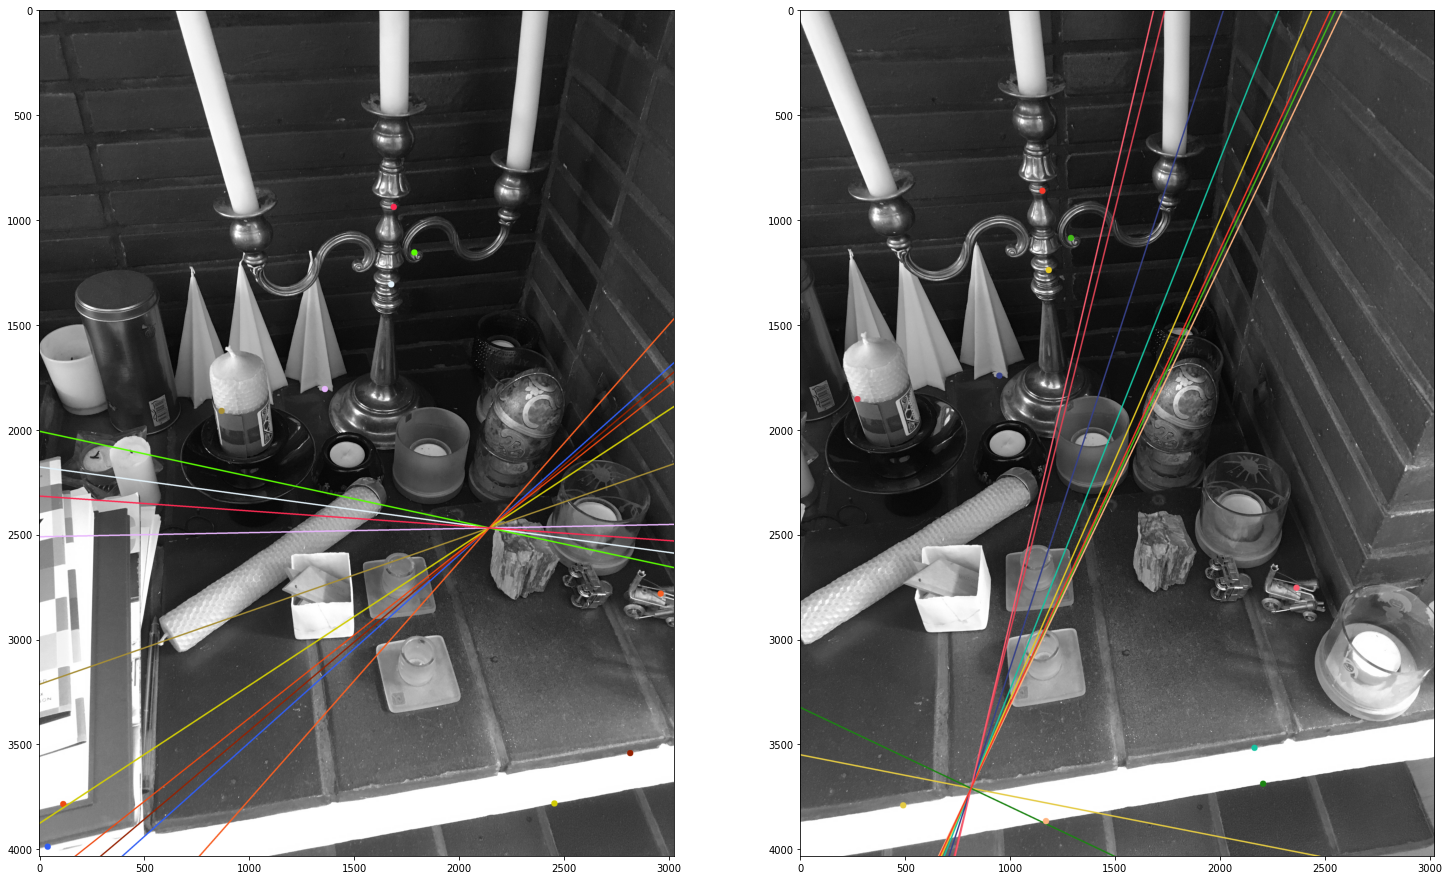

[  41 3987]


In [225]:
pts1 = np.array(_pts1, dtype=int).squeeze()[:10]
pts2 = np.array(_pts2, dtype=int).squeeze()[:10]
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,5)
        img1 = cv2.circle(img1,tuple(pt1),15,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),15,color,-1)
    return img1,img2

print(np.shape(pts1))
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(25, 25))
plt.subplot(122),plt.imshow(img3)
plt.subplot(121),plt.imshow(img5)
plt.show()
print(pts1[0])